In [1]:
import os
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

import plotly
from fbprophet import Prophet

In [2]:
df_sales = pd.read_csv('sales_train_v2.csv')

In [3]:
df_sales_fbprophet = df_sales.loc[(df_sales['item_cnt_day']>0)&
                                (df_sales['item_id']==969)]
df_sales_fbprophet = df_sales_fbprophet.groupby(['date'])['item_cnt_day'].sum().reset_index(name='item_cnt_day_total')
df_sales_fbprophet


,date,item_cnt_day_total
0,01.07.2014,2.0
1,01.08.2014,2.0
2,01.09.2014,1.0
3,01.10.2014,1.0
4,01.11.2014,1.0
...,...,...
131,30.09.2014,1.0
132,30.11.2014,1.0
133,31.03.2015,1.0
134,31.07.2014,1.0


In [4]:
df_sales_fbprophet = df_sales_fbprophet.rename(columns={"date": "ds", "item_cnt_day_total": "y"})
df_sales_fbprophet

,ds,y
0,01.07.2014,2.0
1,01.08.2014,2.0
2,01.09.2014,1.0
3,01.10.2014,1.0
4,01.11.2014,1.0
...,...,...
131,30.09.2014,1.0
132,30.11.2014,1.0
133,31.03.2015,1.0
134,31.07.2014,1.0


In [5]:
m = Prophet(daily_seasonality=False, yearly_seasonality=True)
m.fit(df_sales_fbprophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [6]:
# predict 53 days into the future so we have a full month in January
future = m.make_future_dataframe(periods=53)
future.tail()

,ds
184,2016-01-27
185,2016-01-28
186,2016-01-29
187,2016-01-30
188,2016-01-31


In [7]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
184,2016-01-27,-1.553215,-3.549143,0.471282
185,2016-01-28,-1.532300,-3.581884,0.445283
186,2016-01-29,-1.395907,-3.424031,0.821571
187,2016-01-30,-0.644203,-2.634272,1.548014
188,2016-01-31,-1.146835,-3.280434,0.856670


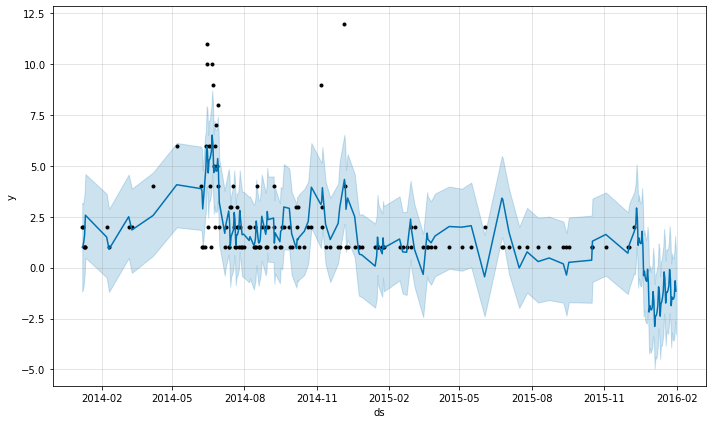

In [8]:
fig1 = m.plot(forecast)